In [1]:
import nengo
import nengo_spa as spa
import nengolib
import nengo_extras
import pytry
import numpy as np
import pylab
import pandas as pd
import seaborn as sns
import itertools
import scipy
import string
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from nengo_extras.plot_spikes import (
    cluster, merge, plot_spikes, preprocess_spikes, sample_by_variance)
from nengo.utils.ensemble import response_curves, tuning_curves

import os
import sys

%pylab inline
import pylab
import cycler
import matplotlib.collections as mcol

%run ../dashedlines.py
%run ../UTC.py

Populating the interactive namespace from numpy and matplotlib


/Users/Joost/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False



# Working Memory


### Visual Explanation

In [3]:
with spa.Network(seed=0) as network:
    vector_a = np.array([np.cos(np.pi/10), np.sin(np.pi/10)])
    vector_b = np.array([np.cos(np.pi/10 + np.pi/2), np.sin(np.pi/10 + np.pi/2)])
    
    input_a = nengo.Node(output=vector_a)
    input_b = nengo.Node(output=vector_b)
    
    wm_direct = nengo.Ensemble(n_neurons=100, neuron_type=nengo.Direct(),
                            dimensions=2, radius=1)
    wm_neural = nengo.Ensemble(n_neurons=100, neuron_type=nengo.LIF(),
                              dimensions=2, radius=1)
    
    nengo.Connection(input_a, wm_direct)
    nengo.Connection(input_b, wm_direct)
    
    nengo.Connection(input_a, wm_neural)
    nengo.Connection(input_b, wm_neural)
    
    wm_direct_probe = nengo.Probe(wm_direct)
    wm_neural_probe = nengo.Probe(wm_neural)
    


In [4]:
with nengo.Simulator(network) as sim:
    sim.run(0.2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [5]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

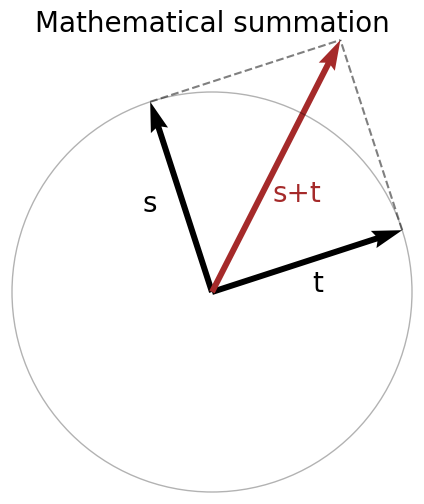

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,6))

ax1.axis('square')
ax1.axis('off')

lim = 1.3
origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point

# Direct (no normalization)
V_direct = np.array([vector_a, vector_b, sim.data[wm_direct_probe][-1,:]])

ax1.set_xlim([-1.01, 1.01])
ax1.set_ylim([-1.01, lim])

ax1.quiver(*origin, V_direct[:,0], V_direct[:,1], scale=1, units='xy',
          color=['black', 'black', 'brown'], width=0.03)

angle = angle_between(V_direct[0,:], V_direct[2,:])
norm = np.linalg.norm(V_direct[2])
ax1.plot([np.cos(angle) * norm * V_direct[0,0], V_direct[2,0]], 
         [np.cos(angle) * norm * V_direct[0,1], V_direct[2,1]], 
         color='black', alpha=0.5, ls='--')

angle = angle_between(V_direct[0,:], V_direct[2,:])
norm = np.linalg.norm(V_direct[2])
ax1.plot([np.cos(angle) * norm * V_direct[1,0], V_direct[2,0]], 
         [np.cos(angle) * norm * V_direct[1,1], V_direct[2,1]], 
         color='black', alpha=0.5, ls='--')

circle1 = plt.Circle((0,0), radius=1, fill=False, alpha=0.3, ls='-')
ax1.add_patch(circle1)

ax1.annotate('t', xy=(0.5, 0), size=20)
ax1.annotate('s', xy=(-0.35, 0.4), size=20)
ax1.annotate('s+t', xy=(0.3, 0.45), size=20, color='brown')

ax1.text(0, 1.3, 'Mathematical summation', ha='center', size=20)

plt.savefig('no_normalization_vectors.png')
fig.savefig('no_normalization.tiff', dpi=1000, bbox_inches='tight')

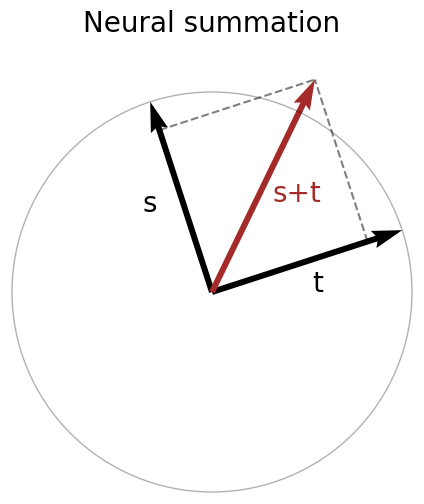

In [7]:
fig, ax2 = plt.subplots(1, 1, figsize=(6,6))

ax2.axis('square')
ax2.axis('off')

lim = 1.3
origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point

# Spiking (normalization)
V_neural = np.array([vector_a, vector_b, nengo.Alpha(0.02).filt(sim.data[wm_neural_probe])[-1,:]],)

ax2.set_xlim([-1.01, 1.01])
ax2.set_ylim([-1.01, lim])

ax2.quiver(*origin, V_neural[:,0], V_neural[:,1], scale=1, units='xy',
           color=['black', 'black', 'brown'], width=0.03)

angle = angle_between(V_neural[0,:], V_neural[2,:])
norm = np.linalg.norm(V_neural[2])
ax2.plot([np.cos(angle) * norm * V_neural[0,0], V_neural[2,0]], 
         [np.cos(angle) * norm * V_neural[0,1], V_neural[2,1]], 
         color='black', alpha=0.5, ls='--')

angle = angle_between(V_neural[1,:], V_neural[2,:])
norm = np.linalg.norm(V_neural[2])
ax2.plot([np.cos(angle) * norm * V_neural[1,0], V_neural[2,0]], 
         [np.cos(angle) * norm * V_neural[1,1], V_neural[2,1]], 
         color='black', alpha=0.5, ls='--')

circle2 = plt.Circle((0,0), radius=1, fill=False, alpha=0.3, ls='-')

ax2.add_patch(circle2)

ax2.annotate('t', xy=(0.5, 0), size=20)
ax2.annotate('s', xy=(-0.35, 0.4), size=20)
ax2.annotate('s+t', xy=(0.3, 0.45), size=20, color='brown')

#ax1.set_title('No normalization', size=20)
#ax2.set_title('Neural normalization', size=20)

ax2.text(0, 1.3, 'Neural summation', ha='center', size=20)

plt.savefig('neural_normalization_vectors.png')
fig.savefig('neural_normalization_vectors.tiff', dpi=1000, bbox_inches='tight')



Text(0, 1.3, 'Neural Summation')

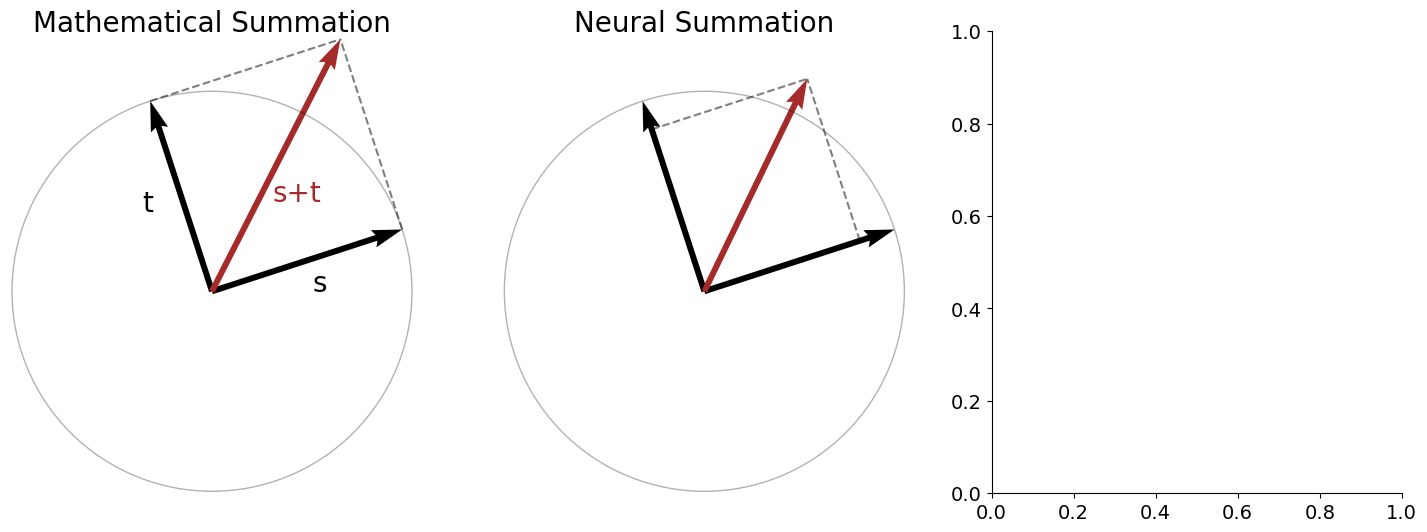

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

ax1.axis('square')
ax2.axis('square')

ax1.axis('off')
ax2.axis('off')

lim = 1.3
origin = np.array([[0, 0, 0],[0, 0, 0]]) # origin point

# Direct (no normalization)
V_direct = np.array([vector_a, vector_b, sim.data[wm_direct_probe][-1,:]])

ax1.set_xlim([-1.01, 1.01])
ax1.set_ylim([-1.01, lim])

ax1.quiver(*origin, V_direct[:,0], V_direct[:,1], scale=1, units='xy',
          color=['black', 'black', 'brown'], width=0.03)

angle = angle_between(V_direct[0,:], V_direct[2,:])
norm = np.linalg.norm(V_direct[2])
ax1.plot([np.cos(angle) * norm * V_direct[0,0], V_direct[2,0]], 
         [np.cos(angle) * norm * V_direct[0,1], V_direct[2,1]], 
         color='black', alpha=0.5, ls='--')

angle = angle_between(V_direct[0,:], V_direct[2,:])
norm = np.linalg.norm(V_direct[2])
ax1.plot([np.cos(angle) * norm * V_direct[1,0], V_direct[2,0]], 
         [np.cos(angle) * norm * V_direct[1,1], V_direct[2,1]], 
         color='black', alpha=0.5, ls='--')

# Spiking (normalization)
V_neural = np.array([vector_a, vector_b, nengo.Alpha(0.02).filt(sim.data[wm_neural_probe])[-1,:]],)

ax2.set_xlim([-1.01, 1.01])
ax2.set_ylim([-1.01, lim])

ax2.quiver(*origin, V_neural[:,0], V_neural[:,1], scale=1, units='xy',
           color=['black', 'black', 'brown'], width=0.03)

angle = angle_between(V_neural[0,:], V_neural[2,:])
norm = np.linalg.norm(V_neural[2])
ax2.plot([np.cos(angle) * norm * V_neural[0,0], V_neural[2,0]], 
         [np.cos(angle) * norm * V_neural[0,1], V_neural[2,1]], 
         color='black', alpha=0.5, ls='--')

angle = angle_between(V_neural[1,:], V_neural[2,:])
norm = np.linalg.norm(V_neural[2])
ax2.plot([np.cos(angle) * norm * V_neural[1,0], V_neural[2,0]], 
         [np.cos(angle) * norm * V_neural[1,1], V_neural[2,1]], 
         color='black', alpha=0.5, ls='--')

circle1 = plt.Circle((0,0), radius=1, fill=False, alpha=0.3, ls='-')
circle2 = plt.Circle((0,0), radius=1, fill=False, alpha=0.3, ls='-')

ax1.add_patch(circle1)
ax2.add_patch(circle2)

ax1.annotate('s', xy=(0.5, 0), size=20)
ax1.annotate('t', xy=(-0.35, 0.4), size=20)
ax1.annotate('s+t', xy=(0.3, 0.45), size=20, color='brown')

#ax1.set_title('No normalization', size=20)
#ax2.set_title('Neural normalization', size=20)

ax1.text(0, 1.3, 'Mathematical Summation', ha='center', size=20)
ax2.text(0, 1.3, 'Neural Summation', ha='center', size=20)

#plt.savefig('normalization_vectors.png')

In [9]:
neuron = 3

inputs = np.zeros((1000, 2))
inputs[:, 0] = np.linspace(-1, 2, 1000)
inputs[:, 1] = 0.
eval_points, activities = tuning_curves(wm_neural, sim, inputs=inputs)

ax3.axis('off')

axins = ax3.inset_axes([0.05, 0.05, 0.9, 0.8])

axins.plot(inputs[:,0], activities[:,neuron],
        color='black', lw=3)

axins.set_xlabel('input', size=20)
axins.set_ylabel('firing rate (Hz)', size=20)

axins.arrow(0, 0, 1.5, 0, length_includes_head=True, overhang=0.2,
          head_width=10, head_length=0.1, lw=3, color='brown')

#slope = activities[286, neuron] - activities[285, neuron]

#ax3.plot(inputs[:,0], activities[285, neuron] + inputs[:,0]*slope*300,
#        lw=3, ls='--', color='grey')

#ax3.set_ylim((-40, 350))

axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)

#ax3.set_title('Neural saturation', size=20, y=0.8)
ax3.text(0.5, 1, 'Neural saturation', ha='center', size=20)

#plt.savefig('tuning_curve.png')

Text(0.5, 1, 'Neural saturation')

In [10]:
fig.savefig('normalization_saturation.png', dpi=400, bbox_inches='tight')
fig.savefig('normalization_saturation.tiff', dpi=1000, bbox_inches='tight')

## Set size effects

In [11]:
%%capture

n_trials = 25
D = 64
set_list = ['0',
            'B',
            'B+C',
            'B+C+D',
            'B+C+D+E',
            'B+C+D+E+F',
            'B+C+D+E+F+G',
            'B+C+D+E+F+G+H',
            'B+C+D+E+F+G+H+I',
            'B+C+D+E+F+G+H+I+J',
            'B+C+D+E+F+G+H+I+J+K',
            'B+C+D+E+F+G+H+I+J+K+L',
            'B+C+D+E+F+G+H+I+J+K+L+M']

wm_strength = []
mean_activity = []
std_activity = []

for trial in range(n_trials):
    a_strength = []

    for i in range(len(set_list)):
        with spa.Network(seed=trial) as wm_network:
            def stimulus_function(t):
                if set_list[i] != '0':
                    return 'A+{}'.format(set_list[i])
                else:
                    return 'A'

            vocab = spa.Vocabulary(D, 
                                   pointer_gen=spa.vector_generation.OrthonormalVectors(D, np.random.RandomState(trial)))
            vocab.populate('A;B;C;D;E;F;G;H;I;J;K;L;M')

            stim = spa.Transcode(stimulus_function, output_vocab=vocab)
            wm = spa.State(vocab=vocab, neurons_per_dimension=200)

            stim >> wm

            #nengo.Connection(stim.output, wm.input)

            stim_probe = nengo.Probe(stim.output)
            wm_probe = nengo.Probe(wm.output)
            spike_probes = []
            for p in range(len(wm.all_ensembles)):
                spike_probes.append(nengo.Probe(wm.all_ensembles[p].neurons))

        with nengo.Simulator(wm_network) as sim:
            sim.run(0.2)

            grey_cmap = plt.cm.Greys(np.linspace(0.4, 1, len(set_list)))
            grey_cycler = cycler.cycler('color', grey_cmap)

            a_temp = nengo.Alpha(0.01).filt(spa.similarity(sim.data[wm_probe], vocab['A'].v))
            a_strength.append(a_temp[-1])
            
            temp_activity = []
            for p in range(len(wm.all_ensembles)):
                temp_activity.append(sim.data[spike_probes[p]])
                
            temp_activity = np.concatenate(temp_activity, axis=1)
            
            mean_activity.append(np.mean(nengo.Alpha(0.01).filt(temp_activity), 
                                         axis=1)[-1])
            std_activity.append(np.std(nengo.Alpha(0.01).filt(temp_activity),
                                       axis=1)[-1])
    
    wm_strength.append(a_strength)



In [12]:
wm_strength = np.asarray(wm_strength)

power function r2 = 0.9598925808279827


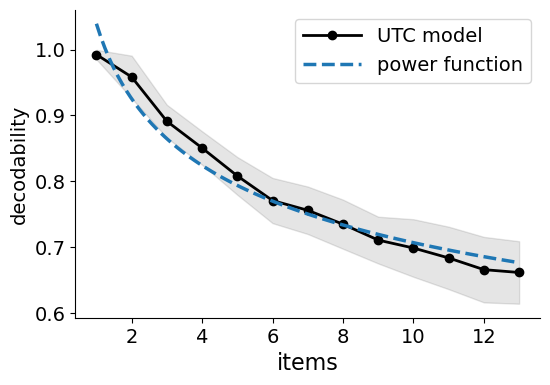

In [13]:
x = np.arange(1, 14)
y = np.squeeze(np.median(wm_strength, axis=0).T)
ystd = np.squeeze(np.std(wm_strength, axis=0).T)

def power_func(n, a, k):
    return a * n**-k

def exp_func(n, a, k):
    return a * k ** n

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(x, y, lw=2, color='black', marker='o', label='UTC model')
ax.fill_between(x, y - ystd, y + ystd,
                alpha=0.1, color='black')

# Power function
params, pcov = scipy.optimize.curve_fit(power_func,  x,  y)
ax.plot(np.linspace(1,13,100), 
        power_func(np.linspace(1,13,100), *params), 
        lw=2.5, ls='--', label='power function')
residuals = y - power_func(x, *params)
ss_res = numpy.sum(residuals**2)
ss_tot = numpy.sum((y-numpy.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print('power function r2 = {}'.format(r_squared))

ax.set_xlabel('items', size=16)
ax.set_xticks(np.array([2, 4, 6, 8, 10, 12]), minor=True)
#plt.minorticks_on()
ax.set_ylabel('decodability')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(fontsize=14, handlelength=3)

fig.savefig('powerlaw.png', dpi=400, bbox_inches='tight')
fig.savefig('powerlaw.tiff', dpi=400, bbox_inches='tight')

### Polti et al. (2018) The effect of attention and working memory on the estimation of elapsed time

In [14]:
# Set parameters
D = 64
dim = 7
dur_list = np.array([30, 60, 90])

N = 1000
theta = 180.

get_dat_method = 'load_raw'

In [15]:
%%capture

if get_dat_method == 'simulate':
    for dur in dur_list:
        # no stimuli
        def stimulus_function(t):
            return 0

        UTC().run(dimensions=dim,
                  N=N,
                  #tau_control=0.05,
                         D=D,
                         full_output=True,
                         direct_mode=False,
                         base_theta=theta,
                         effective_theta=theta,
                         task_type = 'prospective_sensory',
                         stimulus_function=stimulus_function,
                         data_dir='polti_etal_2018',
                         trial_duration=dur,
                         t_offset = dur,
                         store_slice = True,
                         ID=-1)

        # stimuli (load = 0)
        def stimulus_function(t):
            return 'A'
        UTC().run(dimensions=dim,
                  N=N,
                  #tau_control=0.05,
                         D=D,
                         full_output=True,
                         direct_mode=False,
                         base_theta=theta,
                         effective_theta=theta,
                         task_type = 'prospective_sensory',
                         stimulus_function=stimulus_function,
                         data_dir='polti_etal_2018',
                         trial_duration=dur,
                         t_offset = dur,
                         store_slice = True,
                         ID=0)

        # stimuli (load = 1)
        def stimulus_function(t):
            return 'A+B'
        UTC().run(dimensions=dim,
                  N=N,
                  #tau_control=0.05,
                         D=D,
                         full_output=True,
                         direct_mode=False,
                         base_theta=theta,
                         effective_theta=theta,
                         task_type = 'prospective_sensory',
                         stimulus_function=stimulus_function,
                         data_dir='polti_etal_2018',
                         trial_duration=dur,
                         t_offset = dur,
                         store_slice = True,
                         ID=1)

        # stimuli (load = 2)
        def stimulus_function(t):
            return 'A+B+C'
        UTC().run(dimensions=dim,
                  N=N,
                  #tau_control=0.05,
                         D=D,
                         full_output=True,
                         direct_mode=False,
                         base_theta=theta,
                         effective_theta=theta,
                         task_type = 'prospective_sensory',
                         stimulus_function=stimulus_function,
                         data_dir='polti_etal_2018',
                         trial_duration=dur,
                         t_offset = dur,
                         store_slice = True,
                         ID=2)

        # stimuli (load = 3)
        def stimulus_function(t):
            return 'A+B+C+D'
        UTC().run(dimensions=dim,
                  N=N,
                  #tau_control=0.05,
                         D=D,
                         full_output=True,
                         direct_mode=False,
                         base_theta=theta,
                         effective_theta=theta,
                         task_type = 'prospective_sensory',
                         stimulus_function=stimulus_function,
                         data_dir='polti_etal_2018',
                         trial_duration=dur,
                         t_offset = dur,
                         store_slice = True,
                         ID=3)

In [16]:
polti_data = pytry.read('polti_etal_2018')

In [17]:
polti_dt = pd.DataFrame(polti_data)

In [18]:
# Reconstruct vocabulary object
vocab = spa.Vocabulary(int(polti_dt['D'][0]))
for i in range(0, len(polti_dt['sp_keys'][0])):
    vocab.add(polti_dt['sp_keys'][0][i], polti_dt['sp_vectors'][0][i])

/Users/Joost/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


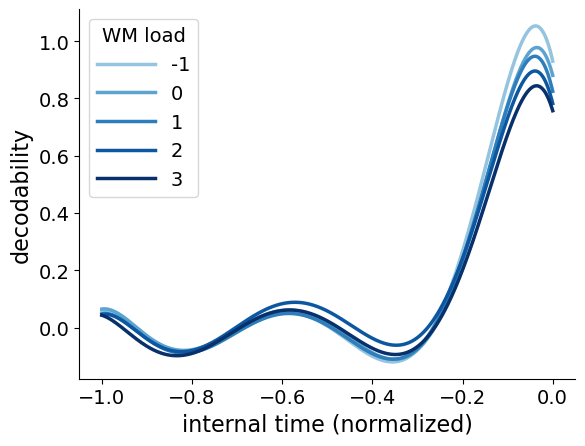

In [19]:
#
fig, ax = plt.subplots()
colors = plt.cm.Blues(np.linspace(0.4, 1, 5))

estimates = []
for dur in [0]:
    pro_state_input = []
    pro_state = []
    for i in [-1, 0, 1, 2, 3]:
        conditions = (polti_dt['ID']==i) & (polti_dt['trial_duration']==dur_list[dur])
        pro_state_input.append(polti_dt[conditions]['state'].values[0])
        pro_state.append(polti_dt[conditions]['x'].values[0])

    temp = []
    for i in range(5):
        x, y = readout_window(np.moveaxis(pro_state[i], 1, 0), D, 
                           readout_time=499, dim=dim, sp=vocab['T'].v)
        plt.plot(np.linspace(-1, 0, num=1000),
                 x, color=colors[i], lw=2.5, label='{}'.format(i-1))

        temp.append(np.mean(abs(x)))
        
    estimates.append(temp)
    ax.set_xlabel('internal time (normalized)', size=16)
    ax.set_ylabel('decodability', size=16)
    ax.legend(title='WM load')
    
estimates = np.asarray(estimates)

#plt.savefig('polti_loadplot.png')

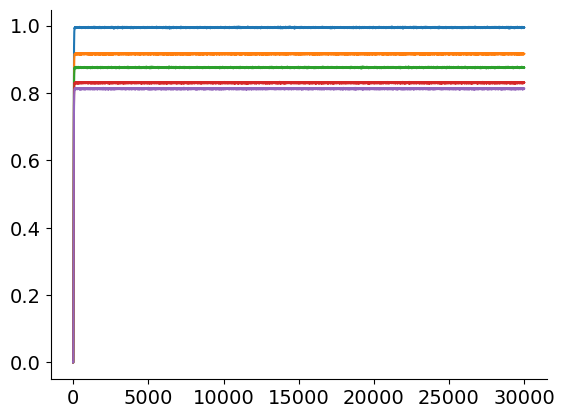

In [20]:
for i in range(5):
    plot(spa.similarity(vocab['T'].v, nengo.Alpha(0.01).filt(pro_state_input[i])))

In [21]:
estimates = []
for dur in range(len(dur_list)):
    pro_state_input = []
    pro_state = []
    for i in [-1, 0, 1, 2, 3]:
        conditions = (polti_dt['ID']==i) & (polti_dt['trial_duration']==dur_list[dur])
        pro_state_input.append(polti_dt[conditions]['state'].values[0])
        pro_state.append(polti_dt[conditions]['x'].values[0])

    temp = []
    for i in range(5):
        x, y = readout_window(np.moveaxis(pro_state[i], 1, 0), D, 
                           readout_time=499, dim=dim, sp=vocab['T'].v)
        temp.append(np.mean(abs(x)))
        
    estimates.append(temp)
    
estimates = np.asarray(estimates)

In [22]:
estimates*theta

array([[36.57314256, 33.77498223, 33.35376035, 31.86920669, 30.15437169],
       [64.99986288, 59.547955  , 55.78109941, 54.85760519, 48.04384881],
       [89.3629638 , 82.51601993, 70.10136487, 70.27590751, 61.1086912 ]])

In [23]:
# empirical data (Polti et al.)
polti_empirical = [np.array([6.806282722513085,
                             1.8848167539266996, # 30 sec
                             0.41884816753926657, 
                             -2.0418848167539316, 
                             -2.251308900523565]),
                   np.array([5.235602094240839,
                             0.7329842931937165, # 60 sec
                             -2.6178010471204196,
                             -7.329842931937176, 
                             -10.994764397905765]),
                   np.array([5.4450261780104725,
                             -6.4921465968586425, # 90 sec
                             -10.62827225130891,
                             -16.33507853403142,
                             -20.94240837696336])]

In [24]:
# compute subjective duration deviation (sdd)
from sklearn.metrics import r2_score
a = 0
sdd = []
for dur in range(len(dur_list)):
    sdd.append(a + (estimates[dur, :] * theta) - dur_list[dur])

In [25]:
sdd

[array([6.57314256, 3.77498223, 3.35376035, 1.86920669, 0.15437169]),
 array([  4.99986288,  -0.452045  ,  -4.21890059,  -5.14239481,
        -11.95615119]),
 array([ -0.6370362 ,  -7.48398007, -19.89863513, -19.72409249,
        -28.8913088 ])]

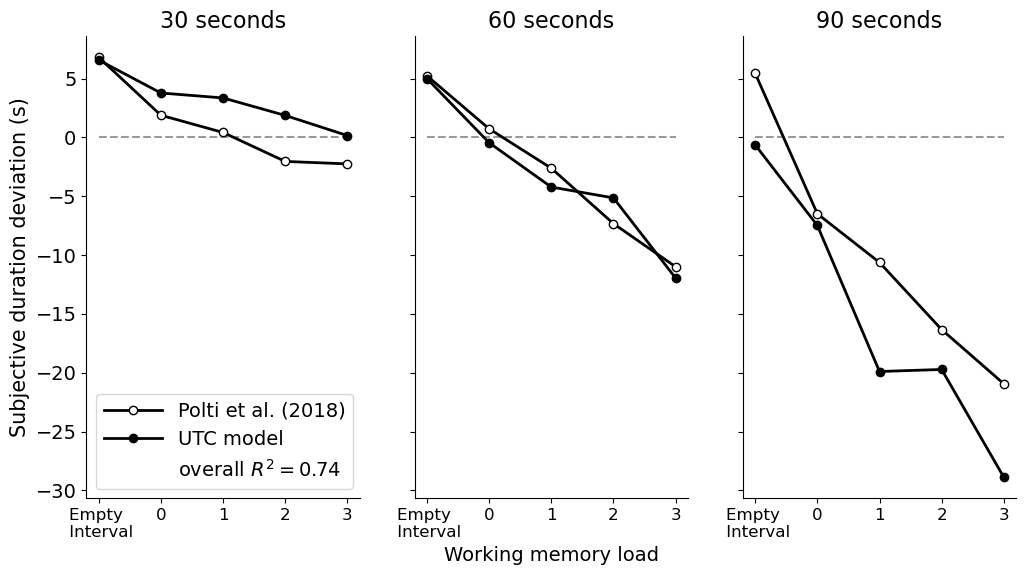

In [26]:
polti_r2 = r2_score(np.concatenate(polti_empirical),
                    np.concatenate(sdd))

fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True)
for dur in range(len(dur_list)):
    ax[dur].plot([-1, 0, 1, 2, 3],
            polti_empirical[dur][:], color='black',
            marker='o', mfc='white', mec='black',
            lw=2, label='Polti et al. (2018)')
    
    ax[dur].plot([-1, 0, 1, 2, 3],
            sdd[dur],
            marker='o', color='black', lw=2,
            label='UTC model')
    
    ax[dur].hlines(y=0, xmin=-1, xmax=3, ls='dashed', alpha=0.4, color='black')
    ax[dur].set_xticks([-1, 0, 1, 2, 3])
    ax[dur].set_xticklabels(['Empty \n Interval', 0, 1, 2, 3], size=12)
    ax[dur].set_title('{} seconds'.format(dur_list[dur]), size=16)

ax[0].plot([], [], ' ', label='overall $R^2 = {:.2f}$'.format(polti_r2))
ax[0].legend(fontsize=14, handlelength=3,
             loc='lower left')

ax[0].set_ylabel('Subjective duration deviation (s)', size=15)
ax[1].set_xlabel('Working memory load', size=14)

plt.savefig('polti_etal.png', bbox_inches='tight')
fig.savefig('polti_etal.tiff', dpi=400, bbox_inches='tight')

(-32.5, 22.5, -32.5, 22.5)

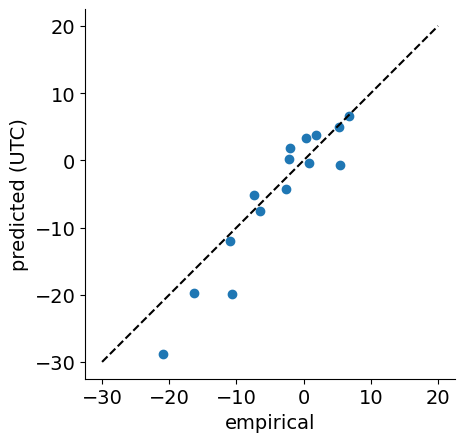

In [27]:
fig, ax = plt.subplots(1, 1)

ax.scatter(np.concatenate(polti_empirical),
        np.concatenate(sdd))
ax.set_xlim([-30, 20])
ax.set_ylim([-30, 20])
ax.plot([-30, 20], [-30, 20], color='black', ls='--')

ax.set_xlabel('empirical')
ax.set_ylabel('predicted (UTC)')
plt.axis('square')